In [235]:
from numpy.random import seed
import tensorflow as tf
tf.random.set_seed(404)

In [218]:
import os
import numpy as np
import pandas as pd
import keras
import itertools

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from IPython.display import display
from tensorflow.keras.utils import array_to_img
from keras.callbacks import TensorBoard

from sklearn.metrics import confusion_matrix

from time import strftime

import matplotlib.pyplot as plt

## Constants

In [114]:
LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse' ,'Ship', 'Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Folder names
LOG_DIR = 'tensorboard_cifar_logs/'

In [11]:
(x_train_all, y_train_all), (x_test, y_test)= cifar10.load_data()

170498071/170498071 [==============================] - 37s 0us/step


## Data exploration

In [15]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

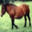

In [21]:
pic = array_to_img(x_train_all[7])
display(pic)

In [25]:
y_train_all

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [24]:
y_train_all[7][0]

7

In [34]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

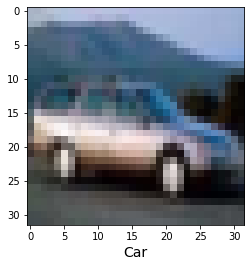

In [42]:
plt.imshow(x_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]], fontsize = 14)
plt.show()

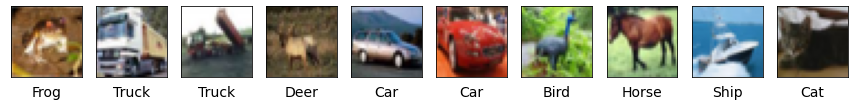

In [55]:
plt.figure(figsize=(15, 5))
for i in range (10):
    plt.subplot(1, 10, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=14)
    plt.imshow(x_train_all[i])

In [56]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [59]:
nr_images, x, y, c = x_train_all.shape
print(f'images = {nr_images} | width = {x} | height = {y} |, channels = {c}')

images = 50000 | width = 32 | height = 32 |, channels = 3


## Preprocess data

In [67]:
type(x_train_all[0][0][0][0]) ## from uint convert to float by dividing by 255

numpy.float64

In [66]:
x_train_all, x_test = x_train_all / 255.0, x_test / 255.0

In [69]:
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)

In [70]:
x_train_all.shape

(50000, 3072)

In [72]:
x_test = x_test.reshape(x_test.shape[0], TOTAL_INPUTS)

In [73]:
x_test.shape

(10000, 3072)

### Create validation set

In [75]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]

In [77]:
x_val.shape

(10000, 3072)

In [83]:
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]

In [85]:
x_train.shape

(40000, 3072)

### Create a small dataset (for illustration)

In [87]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

1st layer = Dense(units = 6, input_dim=3072, ativation='relu') = 32x32x3 image depth
2nd layer = Dense(units=5, activation='relu') - keras is smart enought to know inpur dims
last layer = Dense(units=4, activation='softmax')

## Define NN using Keras

In [150]:
model_1 = Sequential([
        Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
        Dense(units=64, activation='relu', name='m1_hidden2'),
        Dense(units=16, activation='relu', name='m1_hidden3'),
        Dense(units=10, activation='softmax', name='m1_output'),

])

model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [151]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_2.add(Dense(128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_hidden4'))

model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [152]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(128, activation='relu', name='m2_hidden1'))
model_3.add(Dropout(0.25, seed=42))
model_3.add(Dense(64, activation='relu', name='m2_hidden2'))
model_3.add(Dense(16, activation='relu', name='m2_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m2_hidden4'))

model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [100]:
type(model_1)

keras.engine.sequential.Sequential

In [101]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 m1_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [104]:
32*32*3*128+ 128 ##shape*units*bias of first layer

393344

In [112]:
total_params = (32*32*3*128 + 128) +(128*64+ 64) +(64*16+ 16) +(16*10+ 10)
total_params

402810

# Tensorboard (visualising learning)

In [121]:
def get_tensorboard(model_name):

    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_paths = os.path.join(LOG_DIR, folder_name)
    try: 
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')

    return TensorBoard(log_dir=dir_paths)

# Fit the model

In [124]:
samples_per_batch = 1000

In [136]:
# %%time
# nr_epochs = 250
# model_1.fit(x_train_xs, y_train_xs,
#             batch_size=samples_per_batch,
#             epochs=nr_epochs,
#             verbose=0,
#             validation_data=(x_val, y_val),
#             callbacks=[get_tensorboard('Model 1')])

Successfully created directory
CPU times: total: 2min 22s
Wall time: 36.6 s


In [149]:
# %%time
# nr_epochs = 250
# model_2.fit(x_train_xs, y_train_xs,
#             batch_size=samples_per_batch,
#             epochs=nr_epochs,
#             verbose=0,
#             validation_data=(x_val, y_val),
#             callbacks=[get_tensorboard('Model 2')])

Successfully created directory
CPU times: total: 4min 47s
Wall time: 1min 9s


In [153]:
%%time
nr_epochs = 150
model_1.fit(x_train, y_train,
            batch_size=samples_per_batch,
            epochs=nr_epochs,
            verbose=0,
            validation_data=(x_val, y_val),
            callbacks=[get_tensorboard('Model 1 XL')])

Successfully created directory
CPU times: total: 12min 48s
Wall time: 2min 50s


In [154]:
%%time
nr_epochs = 150
model_2.fit(x_train, y_train,
            batch_size=samples_per_batch,
            epochs=nr_epochs,
            verbose=0,
            validation_data=(x_val, y_val),
            callbacks=[get_tensorboard('Model 2 XL')])

Successfully created directory
CPU times: total: 31min 44s
Wall time: 6min 4s


In [155]:
%%time
nr_epochs = 150
model_3.fit(x_train, y_train,
            batch_size=samples_per_batch,
            epochs=nr_epochs,
            verbose=0,
            validation_data=(x_val, y_val),
            callbacks=[get_tensorboard('Model 3 XL')])

Successfully created directory
CPU times: total: 32min 55s
Wall time: 6min 14s


## Predictions

In [158]:
x_val[0].shape

(3072,)

In [160]:
test = np.expand_dims(x_val[0], axis=0)
test.shape

(1, 3072)

In [163]:
model_2.predict(test)

1/1 [==============================] - 0s 26ms/step


array([[0.027, 0.006, 0.024, 0.067, 0.048, 0.049, 0.766, 0.009, 0.002,
        0.001]], dtype=float32)

In [162]:
np.set_printoptions(precision=3)

In [165]:
df_test = pd.DataFrame(model_2.predict(x_val))

313/313 [==============================] - 1s 4ms/step


In [167]:
df_test.columns=LABEL_NAMES

In [168]:
df_test

,Plane,Car,Bird,Cat,Deer,Dog,Frog,Horse,Ship,Truck
0,0.027418,0.006301,0.024237,0.066682,0.047563,0.049364,0.766276,0.009242,0.001790,0.001127
1,0.040292,0.230447,0.001957,0.004177,0.002128,0.003150,0.000053,0.005469,0.076512,0.635814
2,0.001736,0.004150,0.000461,0.004540,0.001486,0.002452,0.000259,0.014444,0.003412,0.967060
3,0.004371,0.000916,0.058908,0.038687,0.215978,0.039132,0.625317,0.014723,0.001106,0.000861
4,0.014006,0.785686,0.000259,0.000069,0.000284,0.000023,0.000011,0.000166,0.113369,0.086128
...,...,...,...,...,...,...,...,...,...,...
9995,0.021848,0.003052,0.577260,0.267537,0.002700,0.107047,0.017944,0.000551,0.000905,0.001156
9996,0.021160,0.018867,0.305623,0.189067,0.100177,0.123427,0.168257,0.019707,0.020011,0.033704
9997,0.000658,0.090350,0.000339,0.003901,0.001064,0.002201,0.001842,0.003289,0.024064,0.872291
9998,0.002221,0.584000,0.006185,0.010661,0.001475,0.005034,0.002203,0.001304,0.037739,0.349177


In [185]:
result = np.where(model_2.predict(test) == model_2.predict(test).max())

1/1 [==============================] - 0s 34ms/step


In [171]:
y_val[0]

array([6], dtype=uint8)

In [188]:
result[1][0]

6

## Evaluation

In [190]:
model_2.metrics_names

['loss', 'accuracy']

In [194]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print(f' Test loss is {test_loss:0.3} and test accuracy is {test_accuracy:0.1%}')

313/313 [==============================] - 1s 4ms/step - loss: 1.4013 - accuracy: 0.5079
 Test loss is 1.4 and test accuracy is 50.8%


## Confusion Metrix

In [205]:
predict = model_2.predict(x_test) 
classes_x = np.argmax(predict, axis=1)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=classes_x)

313/313 [==============================] - 1s 3ms/step


In [206]:
conf_matrix.shape

(10, 10)

In [208]:
conf_matrix.min()

4

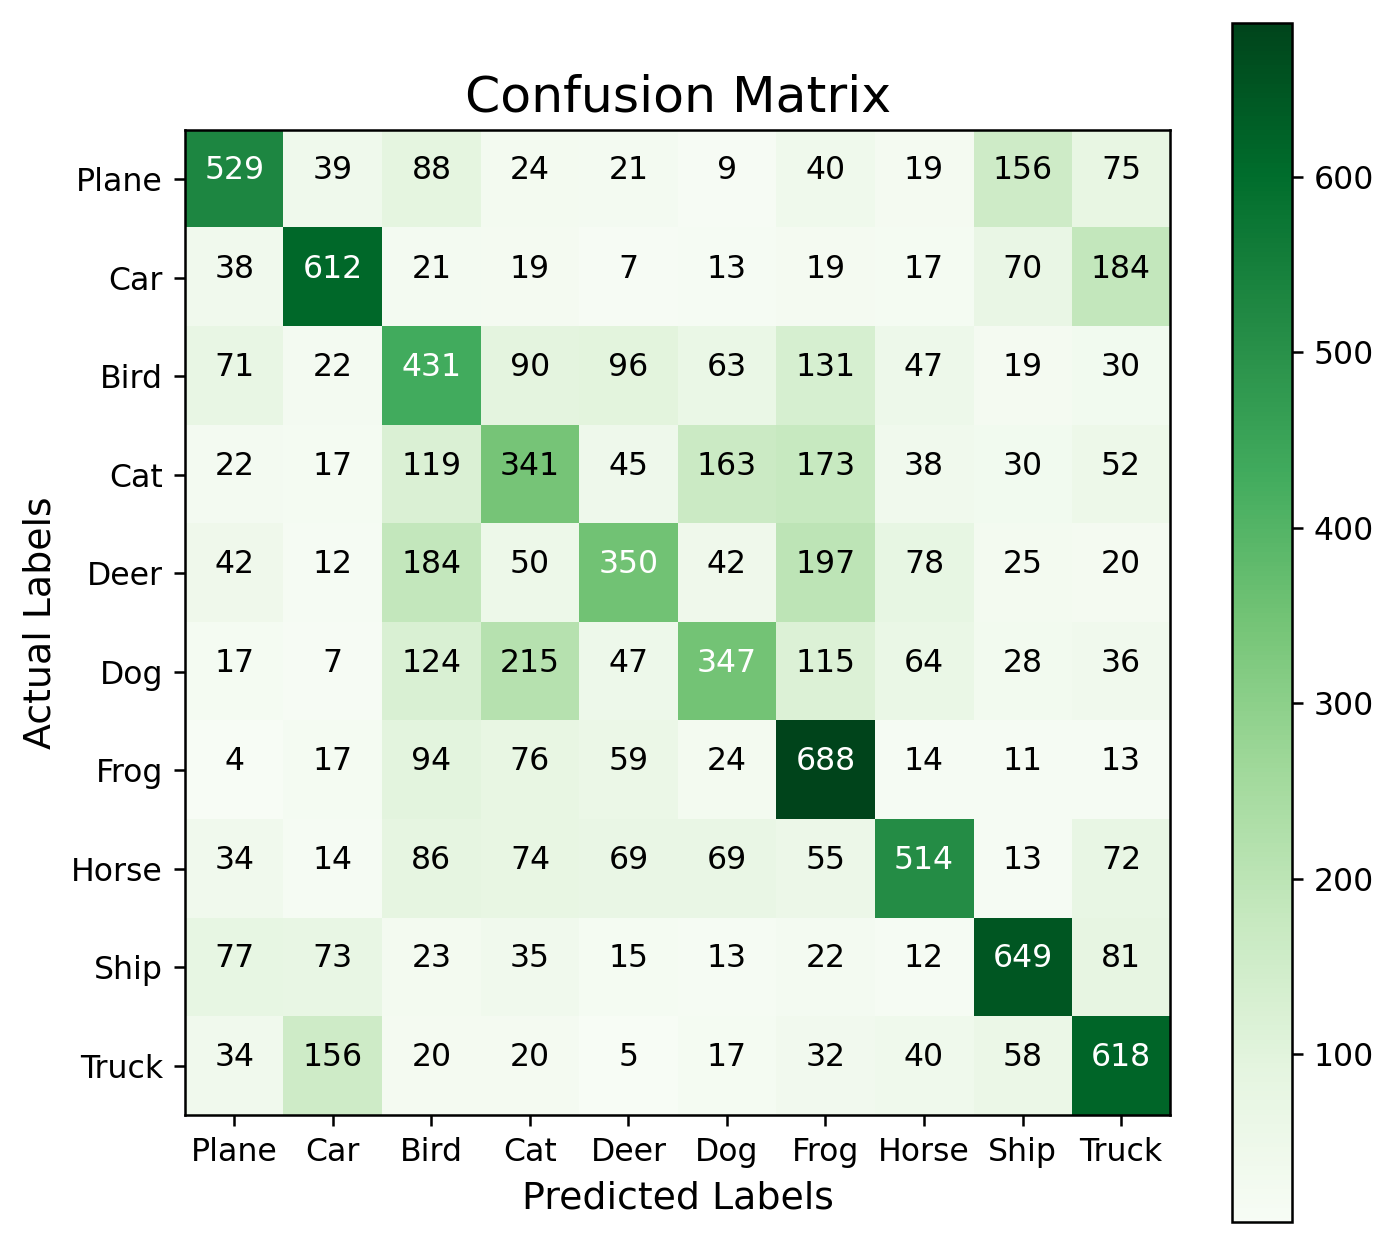

In [228]:
plt.figure(figsize=(7, 7), dpi=227)
plt.imshow(conf_matrix, cmap=plt.cm.Greens)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

tick_marks = np.arange(0,10)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)
plt.colorbar()

for i, j in itertools.product(range(10), range(10)):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment='center',
            color='white' if conf_matrix[i, j]> conf_matrix.max()/2 else 'black')

plt.show()

In [230]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

In [231]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)

In [232]:
avg_recall = np.mean(recall)
print(f'Model 2 recall score is {avg_recall:.2%}')

Model 2 recall score is 50.79%


In [233]:
avg_precision = np.mean(precision)
print(f'Model 2 precision score is {avg_precision:.2%}')

Model 2 precision score is 51.24%


In [234]:
f1_score = 2* ((avg_precision*avg_recall)/(avg_precision+avg_recall))
print(f'Model 2 f1 score score is {f1_score:.2%}')

Model 2 f1 score score is 51.02%
